In [12]:
import os
import itertools
import functools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from bs4 import BeautifulSoup

Extract the information about each trip from the tripinfo.xml for each simulation run.

In [4]:
experiments = os.listdir('../data')

In [5]:
def extract_tripinfo(tripinfo, path):
    vid = tripinfo['id']
    vtype = tripinfo['vType']
    depart_time = float(tripinfo['depart'])
    depart_lane = tripinfo['departLane']
    depart_delay = float(tripinfo['departDelay'])
    arrival_time = float(tripinfo['arrival'])
    arrival_lane = tripinfo['arrivalLane']
    duration = float(tripinfo['duration'])
    route_length = float(tripinfo['routeLength'])
    waiting_time = float(tripinfo['waitingTime'])
    waiting_count = int(tripinfo['waitingCount'])
    time_loss = float(tripinfo['timeLoss'])
    speed_factor = float(tripinfo['speedFactor'])
    
    emissions = tripinfo.find('emissions')
    co_abs = float(emissions['CO_abs'])
    co2_abs = float(emissions['CO2_abs'])
    hc_abs = float(emissions['HC_abs'])
    pmx_abs = float(emissions['PMx_abs'])
    nox_abs = float(emissions['NOx_abs'])
    fuel_abs = float(emissions['fuel_abs'])
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_personinfo(personinfo, path):
    vid = personinfo['id']
    vtype = personinfo['type']
    
    walk = personinfo.find('walk')
    depart_time = float(walk['depart'])
    depart_lane = None
    depart_delay = None
    arrival_time = float(walk['arrival'])
    arrival_lane = None
    duration = float(walk['duration'])
    route_length = float(walk['routeLength'])
    waiting_time = None
    waiting_count = None
    time_loss = float(walk['timeLoss'])
    speed_factor = None
    
    co_abs = 0
    co2_abs = 0
    hc_abs = 0
    pmx_abs = 0
    nox_abs = 0
    fuel_abs = 0
    
    return path, vid, vtype, depart_time, depart_lane, depart_delay, arrival_time, arrival_lane, duration, route_length, waiting_time, waiting_count, time_loss, speed_factor, co_abs, co2_abs, hc_abs, pmx_abs, nox_abs, fuel_abs


def extract_tripinfos(path):
    def curry_extract_tripinfo(tripinfo):
        return extract_tripinfo(tripinfo, path)
    
    def curry_extract_personinfo(personinfo):
        return extract_personinfo(personinfo, path)
    
    with open('../data/{}/tripinfo.xml'.format(path)) as file:
        parsed = BeautifulSoup(file, 'xml')
        
        tripinfos = parsed.find_all('tripinfo')
        personinfos = parsed.find_all('personinfo')
        
        return itertools.chain(map(curry_extract_tripinfo, tripinfos), map(curry_extract_personinfo, personinfos))
    
trips = pd.DataFrame(tqdm(itertools.chain.from_iterable(map(extract_tripinfos, experiments))), columns=[
    'path', 'vid', 'vtype', 'depart_time', 'depart_lane', 'depart_delay', 
    'arrival_time', 'arrival_lane', 'duration', 'route_length', 
    'waiting_time', 'waiting_count', 'time_loss', 'speed_factor',
    'co_abs', 'co2_abs', 'hc_abs', 'pmx_abs', 'nox_abs', 'fuel_abs'
])

0it [00:00, ?it/s]

In [6]:
trips.head()

,path,vid,vtype,depart_time,depart_lane,depart_delay,arrival_time,arrival_lane,duration,route_length,waiting_time,waiting_count,time_loss,speed_factor,co_abs,co2_abs,hc_abs,pmx_abs,nox_abs,fuel_abs
0,aarhus_c_16_p_30,a1_straight_v.0,DEFAULT_VEHTYPE,1.25,gneE19_0,0.0,78.55,gneE15_0,77.30,1535.24,0.00,0.0,3.84,1.20,3108.515612,269114.357891,20.592339,5.237972,105.750861,115.679878
1,aarhus_c_16_p_30,bike_straight_b.0,DEFAULT_BIKETYPE,10.45,24095610_0,0.0,103.25,502199947#0_0,92.80,376.96,18.45,2.0,24.94,0.95,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,aarhus_c_16_p_30,b_right_v.2,DEFAULT_VEHTYPE,41.25,-502199947#0_0,0.0,107.70,gneE6_3,66.45,1092.99,0.00,0.0,4.18,1.23,2293.302575,217141.255108,15.467199,3.926043,86.562311,93.338964
3,aarhus_c_16_p_30,b_right_v.0,DEFAULT_VEHTYPE,26.00,-502199947#0_0,0.0,111.40,gneE6_2,85.40,1092.99,3.00,1.0,8.70,1.00,2900.242677,220442.442349,18.339655,3.710488,87.432148,94.758786
4,aarhus_c_16_p_30,a2_right_v.2,DEFAULT_VEHTYPE,12.50,gneE14_2,0.0,113.25,502199947#0_1,100.75,981.34,23.95,1.0,27.94,0.98,5690.255502,230446.262340,31.256636,4.083491,93.174272,99.060921


Extract control and prediction horizon

In [14]:
def extract_part_n(part, path):
    if 'timed' in path:
        return 0
    
    return int(path.split('_')[part])

trips['c'] = trips['path'].map(functools.partial(extract_part_n, 2))
trips['p'] = trips['path'].map(functools.partial(extract_part_n, 4))
trips['timed'] = trips['path'].map(lambda path: 'timed' in path)
trips['intersection'] = trips['path'].map(lambda path: path.split('_')[0])

trips.head()

,path,vid,vtype,depart_time,depart_lane,depart_delay,arrival_time,arrival_lane,duration,route_length,...,co_abs,co2_abs,hc_abs,pmx_abs,nox_abs,fuel_abs,c,p,timed,intersection
0,aarhus_c_16_p_30,a1_straight_v.0,DEFAULT_VEHTYPE,1.25,gneE19_0,0.0,78.55,gneE15_0,77.30,1535.24,...,3108.515612,269114.357891,20.592339,5.237972,105.750861,115.679878,16,30,False,aarhus
1,aarhus_c_16_p_30,bike_straight_b.0,DEFAULT_BIKETYPE,10.45,24095610_0,0.0,103.25,502199947#0_0,92.80,376.96,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,30,False,aarhus
2,aarhus_c_16_p_30,b_right_v.2,DEFAULT_VEHTYPE,41.25,-502199947#0_0,0.0,107.70,gneE6_3,66.45,1092.99,...,2293.302575,217141.255108,15.467199,3.926043,86.562311,93.338964,16,30,False,aarhus
3,aarhus_c_16_p_30,b_right_v.0,DEFAULT_VEHTYPE,26.00,-502199947#0_0,0.0,111.40,gneE6_2,85.40,1092.99,...,2900.242677,220442.442349,18.339655,3.710488,87.432148,94.758786,16,30,False,aarhus
4,aarhus_c_16_p_30,a2_right_v.2,DEFAULT_VEHTYPE,12.50,gneE14_2,0.0,113.25,502199947#0_1,100.75,981.34,...,5690.255502,230446.262340,31.256636,4.083491,93.174272,99.060921,16,30,False,aarhus


To be useful for an analysis, we need to convert the route to a signal because the exit direction and the particular lane is irrelevant, as long as it remains the same signal.

In [21]:
def convert_route_to_signal(row):
    path, route = row['path'], row['route']
    if 'aarhus' in path:
        route_to_signal = {
            'a1_left_v': 'a1 left',
            'a1_straight_v': 'a1',
            'a2_right_b': 'a2 bike',
            'a2_right_v': 'a2 right',
            'a2_straight_b': 'a2 bike',
            'a2_straight_v': 'a2 straight',
            'b_left_v': 'b',
            'b_right_b': 'b',
            'b_right_v': 'b',
            'bike_straight_b': 'b bike',
            'personFlow_1': 'pedestrian'
        }
        
        return route_to_signal[route]
    else:
        return route
    
trips['route'] = trips['vid'].map(lambda vid: vid.split('.')[0])
trips['signal'] = trips[['path', 'route']].apply(convert_route_to_signal, axis=1)

In [22]:
variable_prediction_horizon = trips[trips['c'] == trips['p']].copy()
constant_prediction_horizon = trips[trips['p'] == 30].copy()

def extract_legend(prefix, path):
    parts = path.split('_')
    name = {
        'fourway': '4-way intersection',
        'aarhus': 'Aarhus intersection'
    }
    
    return prefix + name[parts[0]]

extract_variable_legend = functools.partial(extract_legend, 'Variable prediction horizon - ')
extract_constant_legend = functools.partial(extract_legend, 'Constant prediction horizon - ')

variable_prediction_horizon['legend'] = variable_prediction_horizon['path'].map(extract_variable_legend)
constant_prediction_horizon['legend'] = constant_prediction_horizon['path'].map(extract_constant_legend)

trips = pd.concat([variable_prediction_horizon, constant_prediction_horizon], axis=0)
trips.head()

,path,vid,vtype,depart_time,depart_lane,depart_delay,arrival_time,arrival_lane,duration,route_length,...,pmx_abs,nox_abs,fuel_abs,c,p,timed,intersection,route,signal,legend
1961,aarhus_c_15_p_15,bike_straight_b.0,DEFAULT_BIKETYPE,10.45,24095610_0,0.0,81.45,502199947#0_0,71.00,376.96,...,0.000000,0.000000,0.000000,15,15,False,aarhus,bike_straight_b,b bike,Variable prediction horizon - Aarhus intersection
1962,aarhus_c_15_p_15,a2_right_v.2,DEFAULT_VEHTYPE,12.50,gneE14_2,0.0,87.10,502199947#0_1,74.60,981.34,...,2.363100,61.631200,69.518416,15,15,False,aarhus,a2_right_v,a2 right,Variable prediction horizon - Aarhus intersection
1963,aarhus_c_15_p_15,a1_straight_v.0,DEFAULT_VEHTYPE,1.25,gneE19_0,0.0,104.15,gneE15_0,102.90,1535.24,...,6.889769,136.727594,145.053266,15,15,False,aarhus,a1_straight_v,a1,Variable prediction horizon - Aarhus intersection
1964,aarhus_c_15_p_15,a2_right_v.0,DEFAULT_VEHTYPE,6.15,gneE14_1,0.0,104.25,502199947#0_1,98.10,981.34,...,2.244069,63.388297,71.138019,15,15,False,aarhus,a2_right_v,a2 right,Variable prediction horizon - Aarhus intersection
1965,aarhus_c_15_p_15,b_right_v.0,DEFAULT_VEHTYPE,26.00,-502199947#0_0,0.0,105.65,gneE6_2,79.65,1092.99,...,3.350135,80.830852,88.742620,15,15,False,aarhus,b_right_v,b,Variable prediction horizon - Aarhus intersection


# Analysis

Since we're going to repeat this analysis twice, let's just define it as a function

Average timed time loss: 126.12254840724547


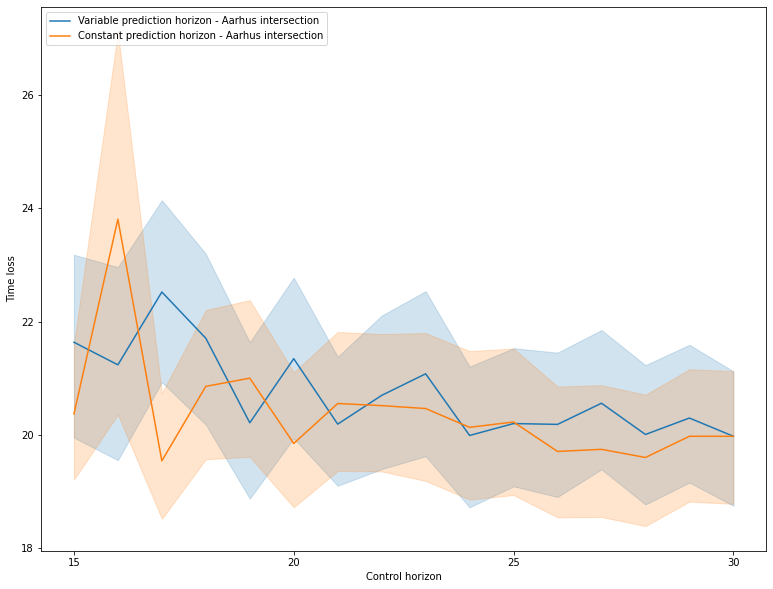

In [38]:

def time_loss(intersection, timed_data, nontimed_data):
    plt.figure(figsize=(13, 10))

    sns.lineplot(x='c', y='time_loss', hue='legend', ci=99, data=nontimed_data)
    
    avg_timed_time_loss = timed_data['time_loss'].mean()
    print('Average timed time loss: {}'.format(avg_timed_time_loss))
    
    plt.plot([15, 30], [avg_timed_time_loss, avg_timed_time_loss], 'r-', label='Avg. time loss for a time intersection')

    plt.legend(loc='upper left')
    plt.ylabel('Time loss')
    plt.xlabel('Control horizon')
    plt.xticks(np.arange(15, 31, 5))

    plt.savefig('{}_time_loss.pdf'.format(intersection), format='pdf', bbox_inches='tight')

def analyze(intersection):
    data = trips[trips['intersection'] == intersection]
    
    timed_data = data[data['timed']]
    nontimed_data = data[~data['timed']]
    
    time_loss(intersection, timed_data, nontimed_data)
    
analyze('aarhus')